# **COMPAS Machine Bias - Case Study Analysis**

**Artificial Intelligence and Society 2024/2025**

**Group CS1:**

- Daniel Carneiro
- Athos Freitas
- Gonçalo Costa
- José Santos
- Luís Du


## **Table of Contents**

- [Introduction](#introduction)

- [Setup](#setup)

- [Data Understanding](#data-understanding)
    - [Initial Data Collection](#initial-data-collection)
    - [Data Description](#data-description)
    - [Exploratory Data Analysis](#exploratory-data-analysis)
  
- [Data Preparation](#data-preparation)
    - [Feature Selecting](#feature-selecting)
    - [Data Filtering](#data-filtering)
    - [Feature Engineering](#feature-engineering)
    - [One-hot Encoding](#one-hot-encoding)
  
- [Logistic Regression Classifier](#logistic-regression-classifier)

- [Aequitas](#aequitas)
    - [Reference Defendant](#reference-defendant)
    - [Audit](#audit)
    - [Group](#group)
    - [Bias](#bias)

- [FairLearn](#fairlearn)
    - [Gender Disparities](#gender-disparities)
    - [Age Disparities](#age-disparities)
    - [Equalized Odds Difference](#equalized-odds-difference)
    - [True Positive Rate](#true-positive-rate)
    - [False Negative Rate](#false-negative-rate)

- [AIF360](#aif360)
    - [Disparate Impact](#disparate-impact)
    - [Statistical Parity Difference](#statistical-parity-difference)

## **Introduction**

**COMPAS** is an algorithmic system used in the US criminal justice system to predict the risk of criminal recidivism. It has gained notoriety for accusations of racial bias, as studies show that black people tend to receive unfairly higher risk assessments when compared to white people with similar criminal histories. This case raises ethical questions about the use of AI in decisions that affect people’s freedom, involving issues such as fairness, transparency, accountability and algorithmic discrimination.

## **Setup**

In [1803]:
import warnings
warnings.filterwarnings('ignore')

In [1804]:
%pip install aequitas aif360 fairlearn aif360[inFairness]

Note: you may need to restart the kernel to use updated packages.


In [1805]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import Markdown
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from aequitas import Audit
from aequitas.bias import Bias
from aequitas.group import Group

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate, true_positive_rate, true_negative_rate,equalized_odds_difference

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

## **Data Understanding**

In this section, we begin by analyzing the ProPublica dataset featured in an article on bias in COMPAS.

### **Initial Data Collection** 

In [1806]:
raw_data = pd.read_csv("compas-scores-two-years.csv")
raw_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [1807]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

### **Data Description** 

The data includes **7214** records of individuals in Broward County, Florida, and **53 features** such as:
  
- **Demographics**: Age, race, gender, etc.
  
- **Criminal history**: Prior offenses, charge degrees, and dates.
  
- **COMPAS scores**: Risk of recidivism (low, medium, or high).
  
- **Outcome**: Actual recidivism within a defined time window

In [1808]:
raw_data.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


#### ➜ **Number of observations and variables**

In [1809]:
raw_data.shape

(7214, 53)

#### ➜ **Missing values**

In [1810]:
raw_data.isnull().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

#### ➜ **Duplicate rows**

In [1811]:
raw_data.duplicated().sum()

np.int64(0)

#### ➜ **Duplicate columns**

In [1812]:
for i, col in enumerate(raw_data.columns):
    for j, col2 in enumerate(raw_data.columns):
        if i < j and raw_data[col].equals(raw_data[col2]):  
            print(f"{col} and {col2} are equal")

compas_screening_date and screening_date are equal
compas_screening_date and v_screening_date are equal
decile_score and decile_score.1 are equal
priors_count and priors_count.1 are equal
screening_date and v_screening_date are equal


### **Exploratory Data Analysis**

In [1813]:
def print_stats(df, feature):
    table = '| Label | Count | Percentage |\n| --- | --- | --- |\n'
    feature_with_na = df[feature].fillna('Missing')
    for label in feature_with_na.value_counts().index:
        count = feature_with_na.value_counts()[label]
        percentage = count / len(df) * 100
        table += '| {} | {} | {:.2f} % |\n'.format(label, count, percentage)
        
    return Markdown(table)

def plot_dist(df, feature):
    pd.crosstab(df[feature].fillna('Missing'), df['decile_score']).plot(kind='bar', stacked=True)
    plt.title(f'{feature} distribution')
    plt.xticks(rotation=45)
    plt.show()

#### **➜ Gender Distribution**

In [1814]:
print_stats(raw_data, 'sex')

| Label | Count | Percentage |
| --- | --- | --- |
| Male | 5819 | 80.66 % |
| Female | 1395 | 19.34 % |


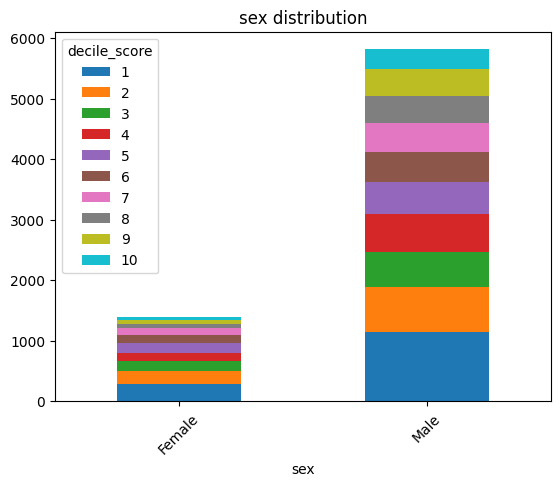

In [1815]:
plot_dist(raw_data, 'sex')

#### **➜ Age Categorization**

In [1816]:
print_stats(raw_data, 'age_cat')

| Label | Count | Percentage |
| --- | --- | --- |
| 25 - 45 | 4109 | 56.96 % |
| Greater than 45 | 1576 | 21.85 % |
| Less than 25 | 1529 | 21.19 % |


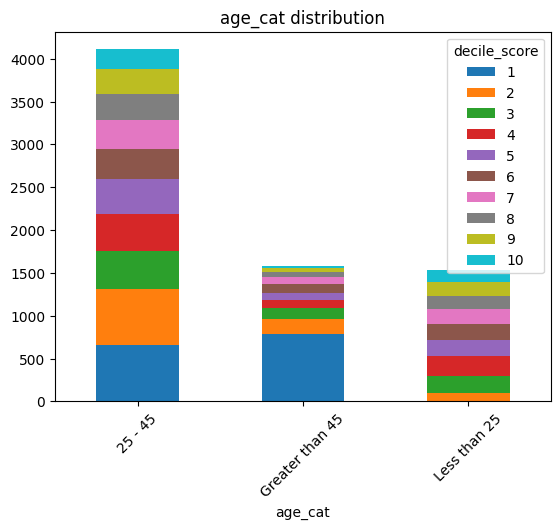

In [1817]:
plot_dist(raw_data, 'age_cat')

#### **➜ Two-year recidivism rate**

In [1818]:
print_stats(raw_data, 'two_year_recid')

| Label | Count | Percentage |
| --- | --- | --- |
| 0 | 3963 | 54.93 % |
| 1 | 3251 | 45.07 % |


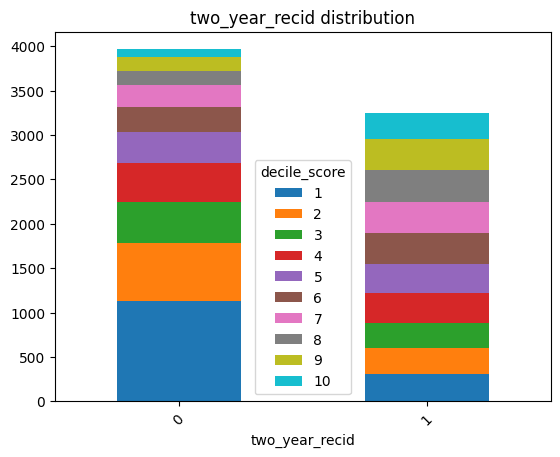

In [1819]:
plot_dist(raw_data, 'two_year_recid')

#### **➜ Decile_score distribution by Race for African-American and Caucasian defendants**

This cell visualizes the distribution of **decile_score** values for African-American and Caucasian defendants, providing insight into score differences across racial groups.

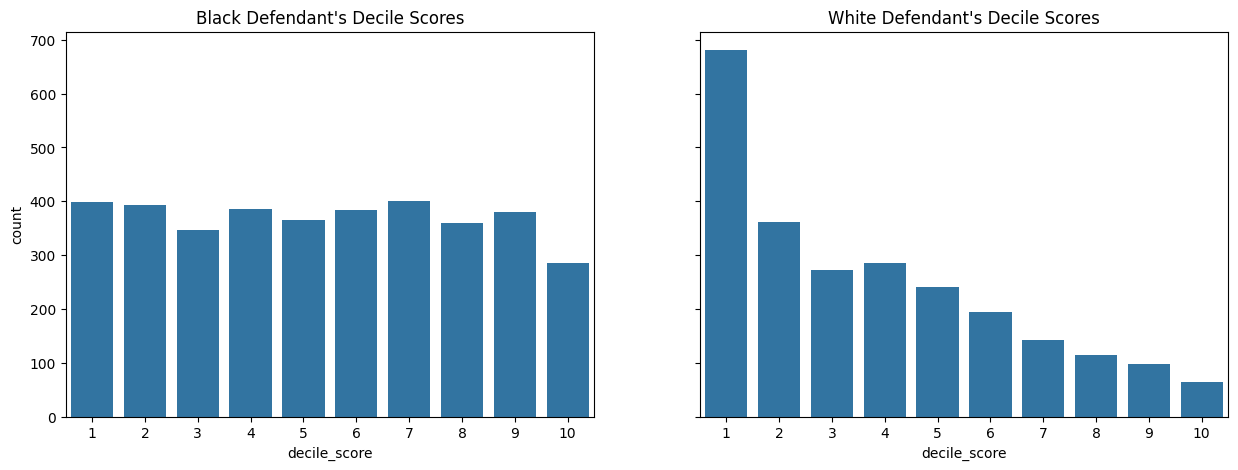

In [1820]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(x="decile_score", data=raw_data[raw_data['race'] == "African-American"], ax=axes[0])
axes[0].set_title("Black Defendant's Decile Scores")
sns.countplot(x="decile_score", data=raw_data[raw_data['race'] == "Caucasian"], ax=axes[1])
axes[1].set_title("White Defendant's Decile Scores")
plt.show()

#### **➜ Demographic Breakdown**

In [1821]:
print_stats(raw_data, 'race')

| Label | Count | Percentage |
| --- | --- | --- |
| African-American | 3696 | 51.23 % |
| Caucasian | 2454 | 34.02 % |
| Hispanic | 637 | 8.83 % |
| Other | 377 | 5.23 % |
| Asian | 32 | 0.44 % |
| Native American | 18 | 0.25 % |


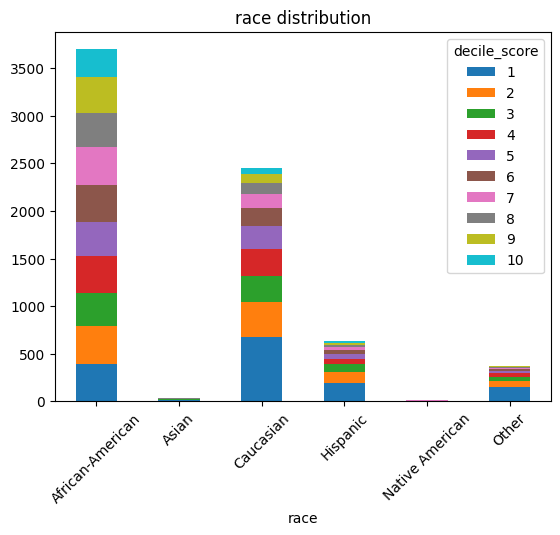

In [1822]:
plot_dist(raw_data, 'race')

#### **➜ Correlation Matrix**

Text(0.5, 1.0, 'Correlation Matrix')

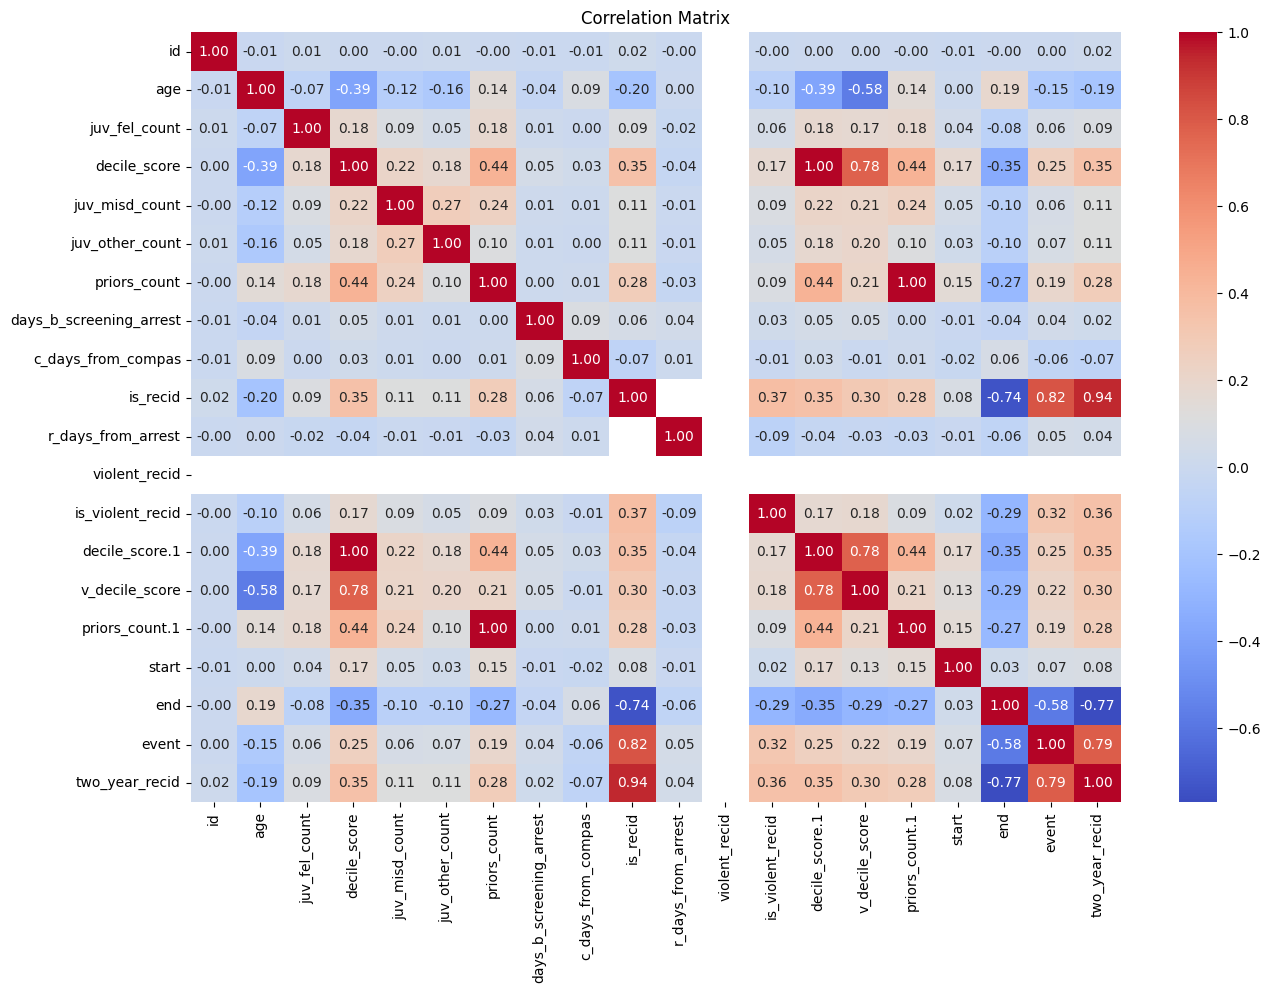

In [1823]:
numerical_features = raw_data.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")

---

## **Data Preparation**

### **Feature Selecting**

The original dataset consists of **7214** rows and **52 features**. However, several features, such as name, last name, middle name, and dates, are irrelevant to the case study. These features can be removed to focus on the most informative and relevant variables for analysis.

We will start by selecting only some features we consider relevant:

In [1824]:
relevant_features =['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
               'two_year_recid', 'c_jail_in', 'c_jail_out', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'r_charge_degree', 'is_violent_recid', 'vr_charge_degree', 'v_score_text']

df = raw_data[relevant_features]

### **Data Filtering**

Some records contain data quality issues based on specific context rules. For example, if the charge date of a defendant's COMPAS-scored crime does not fall within 30 days of their arrest date, the offense may not be correctly identified.

In [1825]:
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]

After data filtering, there is no more missing values in the dataset.

### **Feature engineering**

Among the selected features, `c_jail_in` and `c_jail_out` are in DateTime format and, on their own, provide limited value to the model. To make this information more useful, we will create a new feature `length_of_stay` that calculates the time difference between these two dates, representing the duration of the jail stay.

In [1826]:
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])

df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days

df = df.drop(columns=['c_jail_in', 'c_jail_out'])

Now, we can examine the correlation between the length of jail stay and the obtained COMPAS scores. This will help us understand if the duration of incarceration has any relationship with the scoring outcomes.

In [1827]:
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length of stay and decile score: {correlation:.2f}")

Correlation between length of stay and decile score: 0.21


### **One hot encoding**

In [1828]:
o_df = df.copy()
df = pd.get_dummies(df, columns=['c_charge_degree', 'age_cat', 'race', 'sex'], drop_first=True)
df['score_factor'] = np.where(df['score_text'] != "Low", 1, 0)

---

## **Logistic Regression Classifier**

In [1829]:
X_columns = [
    'sex_Male', 'age_cat_Greater than 45', 'age_cat_Less than 25',
    'race_Asian', 'race_Hispanic', 'race_Native American',
    'race_Other', 'priors_count', 'two_year_recid', 'length_of_stay'
]

X = df[X_columns].copy()
y = df['score_factor']

scaler = StandardScaler()
X[['priors_count', 'length_of_stay']] = scaler.fit_transform(X[['priors_count', 'length_of_stay']])

log_reg = LogisticRegression()
log_reg.fit(X, y)

y_pred = log_reg.predict(X)

df['score_factor'] = y
df['predicted_score'] = y_pred
df[['c_charge_degree', 'age_cat', 'race', 'sex']] = o_df[['c_charge_degree', 'age_cat', 'race', 'sex']]

---

## **Aequitas**

Aequitas is an open-source bias audit toolkit developed to evaluate fairness in machine learning models, particularly in critical domains like criminal justice, healthcare, and finance. 

It provides a systematic framework to assess algorithmic fairness by measuring disparities in model performance across different demographic groups.

In [1830]:
columns = [
    "sex", "age_cat", "race", "juv_fel_count", "decile_score", "juv_misd_count", "juv_other_count",
    "c_charge_degree", "is_recid", "r_charge_degree", "is_violent_recid",
    "vr_charge_degree", "score_text", "v_score_text", "two_year_recid",
    "score_factor", "predicted_score"
]

df = df[columns].dropna()

In [1831]:
for column in df.columns:
    df[column] = df[column].astype('object')

df['score_factor'] = df['score_factor'].astype('int')
df = df[df['race'] != 'Asian']

### **Reference Defendant**

We will use a Caucasian defendant aged 25 to 45 with a low score as the reference.

In [1832]:
reference = df.loc[(df['race'] == 'Caucasian') & (df['sex'] == 'Male') & (df['age_cat'] == '25 - 45') & (df['score_text'] == 'Low')].iloc[0]
reference.drop(['predicted_score', 'score_factor'], inplace=True)
reference = reference.to_dict()

### **Audit**

In [1833]:
audit = Audit(df,
    label_column="predicted_score",
    score_column="score_factor",
    sensitive_attribute_column=["sex", "age_cat", "race", "is_recid", "is_violent_recid", "c_charge_degree", "decile_score", "juv_fel_count", "juv_misd_count", "juv_other_count", "r_charge_degree", "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"],
    reference_groups=reference
)

audit.audit()

### **Confusion Matrix**

In [1834]:
audit.confusion_matrix

pp   pn  fp  fn   tn   tp  group_label_pos  \
attribute_name attribute_value                                                
sex            Female            49   33   9   9   24   40               49   
               Male             401  206  65  71  135  336              407   
age_cat        25 - 45          274  150  52  43  107  222              265   
               Greater than 45   30   52  16   5   47   14               19   
               Less than 25     146   37   6  32    5  140              172   
...                             ...  ...  ..  ..  ...  ...              ...   
v_score_text   High             140    1  13   1    0  127              128   
               Low              120  206  30  58  148   90              148   
               Medium           190   32  31  21   11  159              180   
two_year_recid 0                 21   19  12   3   16    9               12   
               1                429  220  62  77  143  367              444   

                                group_label_neg  group_size  total_entities  
attribute_name attribute_value                                               
sex            Female                        33          82             689  
               Male                         200         607             689  
age_cat        25 - 45                      159         424             689  
               Greater than 45               63          82             689  
               Less than 25                  11         183             689  
...                                         ...         ...             ...  
v_score_text   High                          13         141             689  
               Low                          178         326             689  
               Medium                        42         222             689  
two_year_recid 0                             28          40             689  
               1                            205         649             689  

[74 rows x 10 columns]

### **Metrics**

In [1835]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                 
sex            Female               0.78  0.82  0.73  0.27  0.18  0.27  0.18   
               Male                 0.78  0.83  0.68  0.34  0.16  0.32  0.17   
age_cat        25 - 45              0.78  0.84  0.67  0.29  0.19  0.33  0.16   
               Greater than 45      0.74  0.74  0.75  0.10  0.53  0.25  0.26   
               Less than 25         0.79  0.81  0.45  0.86  0.04  0.55  0.19   
...                                  ...   ...   ...   ...   ...   ...   ...   
v_score_text   High                 0.90  0.99  0.00  1.00  0.09  1.00  0.01   
               Low                  0.73  0.61  0.83  0.28  0.25  0.17  0.39   
               Medium               0.77  0.88  0.26  0.66  0.16  0.74  0.12   
two_year_recid 0                    0.62  0.75  0.57  0.16  0.57  0.43  0.25   
               1                    0.79  0.83  0.70  0.35  0.14  0.30  0.17   

                                 npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                      
sex            Female           0.73       0.82  0.11   0.60  0.60  
               Male             0.66       0.84  0.89   0.66  0.67  
age_cat        25 - 45          0.71       0.81  0.61   0.65  0.62  
               Greater than 45  0.90       0.47  0.07   0.37  0.23  
               Less than 25     0.14       0.96  0.32   0.80  0.94  
...                              ...        ...   ...    ...   ...  
v_score_text   High             0.00       0.91  0.31   0.99  0.91  
               Low              0.72       0.75  0.27   0.37  0.45  
               Medium           0.34       0.84  0.42   0.86  0.81  
two_year_recid 0                0.84       0.43  0.05   0.52  0.30  
               1                0.65       0.86  0.95   0.66  0.68  

[74 rows x 12 columns]

### **Disparities**

In [1836]:
audit.disparities.style

In [1837]:
audit.disparity_plot(metrics=['fpr','tnr'], attribute='race', fairness_threshold=1.25)

alt.LayerChart(...)

### **Group**

In [1838]:
group = Group()
xtab = group.get_crosstabs(df, score_col='score_factor', label_col='predicted_score', attr_cols = ["sex", "age_cat", "race", "is_recid", "is_violent_recid", "c_charge_degree", "decile_score", "juv_fel_count", "juv_misd_count", "juv_other_count", "r_charge_degree", "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"])

xtab = xtab[0]
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,450,sex,Female,0.780488,0.816327,0.727273,0.272727,0.183673,...,0.597561,9,9,24,40,49,33,82,689,0.597561
1,0,binary 0/1,450,sex,Male,0.775947,0.825553,0.675000,0.344660,0.162095,...,0.660626,65,71,135,336,407,200,607,689,0.670511
2,0,binary 0/1,450,age_cat,25 - 45,0.775943,0.837736,0.672956,0.286667,0.189781,...,0.646226,52,43,107,222,265,159,424,689,0.625000
3,0,binary 0/1,450,age_cat,Greater than 45,0.743902,0.736842,0.746032,0.096154,0.533333,...,0.365854,16,5,47,14,19,63,82,689,0.231707
4,0,binary 0/1,450,age_cat,Less than 25,0.792350,0.813953,0.454545,0.864865,0.041096,...,0.797814,6,32,5,140,172,11,183,689,0.939891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0,binary 0/1,450,v_score_text,High,0.900709,0.992188,0.000000,1.000000,0.092857,...,0.992908,13,1,0,127,128,13,141,689,0.907801
70,0,binary 0/1,450,v_score_text,Low,0.730061,0.608108,0.831461,0.281553,0.250000,...,0.368098,30,58,148,90,148,178,326,689,0.453988
71,0,binary 0/1,450,v_score_text,Medium,0.765766,0.883333,0.261905,0.656250,0.163158,...,0.855856,31,21,11,159,180,42,222,689,0.810811
72,0,binary 0/1,450,two_year_recid,0,0.625000,0.750000,0.571429,0.157895,0.571429,...,0.525000,12,3,16,9,12,28,40,689,0.300000


### **Bias**

**Bias** is used to calculate disparities between groups for the predefined list of group metrics using the majority group within each attribute as the reference group (denominator).

In [1839]:
bias = Bias()
hbdf = bias.get_disparity_predefined_groups(df=xtab, original_df=df, ref_groups_dict=reference, alpha=0.05, mask_significance=True)


In [1840]:
hbdf[['attribute_name', 'attribute_value'] + bias.list_disparities(hbdf) + bias.list_significance(hbdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.122195,0.904537,0.974247,1.133124,0.791293,0.839161,1.052889,0.988824,1.077441,1.109764
1,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,age_cat,Greater than 45,0.109489,0.566139,0.575976,2.810256,0.335420,0.776557,1.621787,0.879564,1.108589,1.267074
4,age_cat,Less than 25,0.532847,1.234574,1.183512,0.216544,3.016970,1.667832,1.146566,0.971611,0.675446,0.189442
...,...,...,...,...,...,...,...,...,...,...,...,...
69,v_score_text,High,1.166667,2.697400,1.209524,0.371429,3.551724,5.933333,0.019935,1.631597,0.000000,0.000000
70,v_score_text,Low,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
71,v_score_text,Medium,1.583333,2.325075,1.115789,0.652632,2.330819,4.379365,0.297701,1.452593,0.314994,0.478463
72,two_year_recid,0,0.048951,0.794231,0.500973,3.953917,0.451128,1.417051,1.441558,0.907357,0.819181,1.295547


In [1858]:
majority_bdf = bias.get_disparity_major_group(xtab, original_df=df)
majority_bdf[['attribute_name', 'attribute_value'] +  bias.list_disparities(majority_bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.122195,0.904537,0.974247,1.133124,0.791293,0.839161,1.052889,0.988824,1.077441,1.109764
1,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,age_cat,Greater than 45,0.109489,0.566139,0.575976,2.810256,0.335420,0.776557,1.621787,0.879564,1.108589,1.267074
4,age_cat,Less than 25,0.532847,1.234574,1.183512,0.216544,3.016970,1.667832,1.146566,0.971611,0.675446,0.189442
...,...,...,...,...,...,...,...,...,...,...,...,...
69,v_score_text,High,1.166667,2.697400,1.209524,0.371429,3.551724,5.933333,0.019935,1.631597,0.000000,0.000000
70,v_score_text,Low,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
71,v_score_text,Medium,1.583333,2.325075,1.115789,0.652632,2.330819,4.379365,0.297701,1.452593,0.314994,0.478463
72,two_year_recid,0,0.048951,0.794231,0.500973,3.953917,0.451128,1.417051,1.441558,0.907357,0.819181,1.295547


---

## **FairLearn**

Using FairLearn’s MetricFrame, we can calculate several performance metrics, such as accuracy, precision, recall, false positive rate, and selection rate for different racial groups.

In [1841]:
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'true_positive_rate': true_positive_rate,
    'true_negative_rate': true_negative_rate
}

### **Gender Disparities**

In [1842]:
gender_disparities = MetricFrame(
    metrics=metrics,
    y_true=df['predicted_score'],
    y_pred=df['score_factor'],
    sensitive_features=df['sex']
).difference()

In [1843]:
print(gender_disparities)

accuracy               0.004541
precision              0.021579
recall                 0.009226
selection_rate         0.063065
false_positive_rate    0.052273
false_negative_rate    0.009226
true_positive_rate     0.009226
true_negative_rate     0.052273
dtype: float64


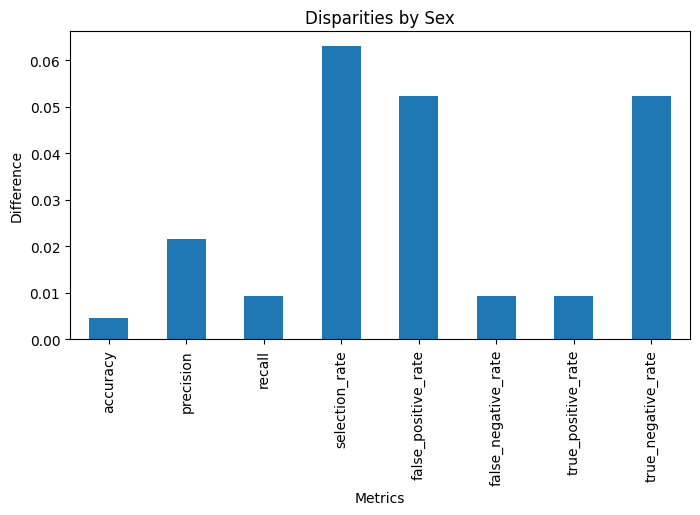

In [1844]:
gender_disparities.plot(kind='bar', figsize=(8, 4))
plt.title('Disparities by Sex')
plt.xlabel('Metrics')
plt.ylabel('Difference')
plt.show()

### **Age Disparities**

In [1845]:
age_disparities = MetricFrame(
    metrics=metrics,
    y_true=df['predicted_score'],
    y_pred=df['score_factor'],
    sensitive_features=df['age_cat']
).difference()

In [1846]:
print(age_disparities)

accuracy               0.048447
precision              0.492237
recall                 0.100894
selection_rate         0.431961
false_positive_rate    0.291486
false_negative_rate    0.100894
true_positive_rate     0.100894
true_negative_rate     0.291486
dtype: float64


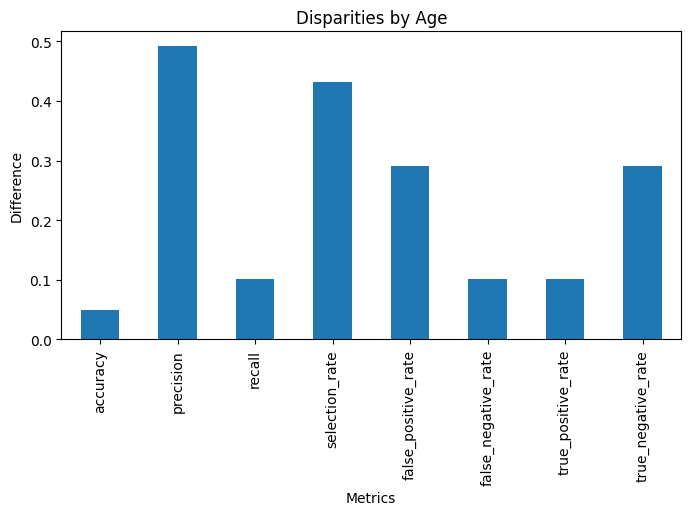

In [1847]:
age_disparities.plot(kind='bar', figsize=(8, 4))
plt.title('Disparities by Age')
plt.xlabel('Metrics')
plt.ylabel('Difference')
plt.show()

### **Equalized Odds Difference**

***equalized_odds_difference*** and ***equalized_odds_ratio***: these measures tell us the disparity between true positives and false positives between groups.

In [1848]:
eod_metrics = dict()

for feature in ['race', 'sex', 'age_cat']:
    eod = equalized_odds_difference(
        y_true=df['predicted_score'],
        y_pred=df['score_factor'],
        sensitive_features=df[feature]
    )
    eod_metrics[feature] = eod
    print(f'Equalized Odds Difference {feature}: {eod}')

Equalized Odds Difference race: 0.3978494623655914
Equalized Odds Difference sex: 0.052272727272727304
Equalized Odds Difference age_cat: 0.29148629148629146


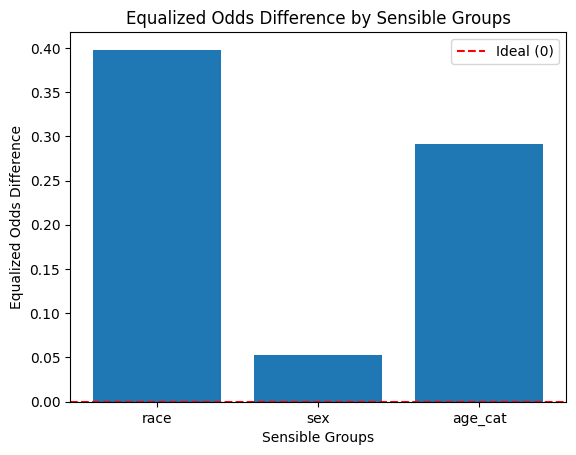

In [1849]:
plt.bar(eod_metrics.keys(), eod_metrics.values())
plt.title('Equalized Odds Difference by Sensible Groups')
plt.ylabel('Equalized Odds Difference')
plt.xlabel('Sensible Groups')
plt.axhline(0, color='red', linestyle='--', label='Ideal (0)')
plt.legend()
plt.show()

### **True Positive Rate**

A high **TPR** means that the model can correctly identify positive cases.

In [1850]:
tpr_race = MetricFrame(
    metrics=true_positive_rate, 
    y_true=df['predicted_score'],
    y_pred=df['score_factor'], 
    sensitive_features=df['race']
)

tpr_ratio = tpr_race.overall / tpr_race.by_group
print(f'Equalized Odds Ratio (TPR): {tpr_ratio}')

Equalized Odds Ratio (TPR): race
African-American    0.973684
Caucasian           1.135266
Hispanic            0.951417
Native American     0.824561
Other               0.907018
Name: true_positive_rate, dtype: float64


### **False Negative Rate**

A Low **FPR** indicates that the model is not generating a lot of false alarms.

In [1851]:
fpr_race = MetricFrame(
    metrics=false_negative_rate, 
    y_true=df['predicted_score'],
    y_pred=df['score_factor'], 
    sensitive_features=df['race']
)

fpr_ratio = fpr_race.overall / fpr_race.by_group
print(f'Equalized Odds Ratio (FPR): {fpr_ratio}')

Equalized Odds Ratio (FPR): race
African-American    1.145511
Caucasian           0.641026
Hispanic            1.315789
Native American          inf
Other               1.929825
Name: false_negative_rate, dtype: float64


---

## **AIF360**

Using AIF360’s BinaryLabelDatasetMetric, an IBM tool used to mitigate and detect BIAS, we used Disparate Impact and Statistical Parity Difference for different racial groups.

In [1852]:
categorical_columns = [
    'score_text', 'v_score_text', 'c_charge_degree', 'age_cat', 'sex',
    'r_charge_degree', 'vr_charge_degree', 'race'
]

label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = df[col].astype(str)
    df[col] = label_encoder.fit_transform(df[col])

df['score_factor'] = df['score_factor'].astype(int)
df['decile_score'] = df['decile_score'].astype(int)

In [1853]:
aif_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=df,
    label_names=['predicted_score'],
    protected_attribute_names=['race']
)

In [1854]:
dataset_metric = BinaryLabelDatasetMetric(
    aif_dataset,
    privileged_groups=[{'race': 1}],
    unprivileged_groups=[{'race': 0}]
)
metrics = dict()

### **Disparate Impact**

The ratio of rate of favorable outcome for the unprivileged group (African-American people) to that of the privileged group (Caucasian people).

In [1855]:
value = dataset_metric.disparate_impact()
metrics['Disparate Impact'] = value
print("Disparate Impact:", value)

Disparate Impact: 0.446215756074911


### **Statistical Parity Difference**

The difference of the rate of favorable outcomes received by the unprivileged group (African-American people) to the privileged group (Caucasian people).

In [1856]:
value = dataset_metric.statistical_parity_difference()
metrics["Statistical Parity Difference"] = value
print("Statistical Parity Difference:", value)

Statistical Parity Difference: -0.27093745267302743


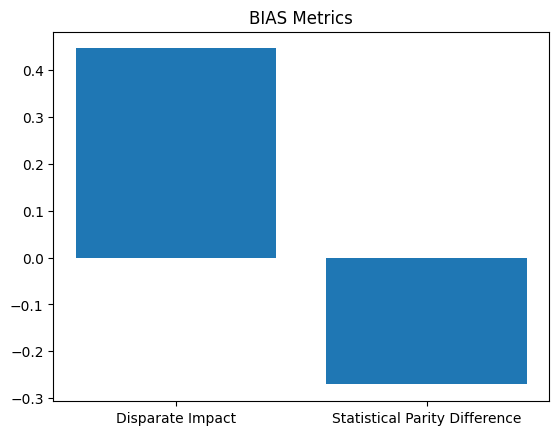

In [1857]:
plt.bar(metrics.keys(), metrics.values())
plt.title("BIAS Metrics")
plt.show()

---

## **References**

**1.** Jeff Larson, Surya Mattu, Lauren Kirchner, and Julia Angwin. "[How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)." Accessed: 2024-10-21.

**2.** "[ProPublica Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)." Accessed: 2024-10-02.

**3.** Northpointe. "[Practitioner’s Guide to COMPAS Core](https://s3.documentcloud.org/documents/2840784/Practitioner-s-Guide-to-COMPAS-Core.pdf)." Published: 19-03-2015. Accessed: 2024-10-02.

**4.** Michelle Bao, Angela Zhou, Samantha Zottola, Brian Brubach, Sarah Desmarais, Aaron Horowitz, Kristian Lum, and Suresh Venkatasubramanian. "It's compaslicated: The messy relationship between RAI datasets and algorithmic fairness benchmarks." *arXiv preprint arXiv:2106.05498*, 2021.

**5.** Sandra G. Mayson. "Bias in, bias out." *YAle LJ*, vol. 128, pp. 2218, 2018.

**6.** HLEG, AI. "Ethics guidelines for trustworthy artificial intelligence." *High-Level Expert Group on Artificial Intelligence*, vol. 8, 2019.

**7.** Data Science for Social Good (DSSG). "[Aequitas: A Bias and Fairness Audit Toolkit](https://github.com/dssg/aequitas)." Accessed: 2024-11-10.

**8.** IBM Research. "[AI Fairness 360 (AIF360): An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted Bias in Machine Learning Models](https://aif360.res.ibm.com/)." Accessed: 2024-11-23.

**9.** Fairlearn Community. "[Fairlearn: A toolkit to assess and improve fairness in machine learning](https://fairlearn.org/)." Accessed: 2024-11-23.

**10.** Your Research Group. "[COMPAS Machine Bias notebook](https://colab.research.google.com/drive/1DY4txRU9GU8O-uXQ3-f85tm3JgqhOoF-?usp=sharing#scrollTo=yIvFSz65400I)." Accessed: 2024-10-02.